
<div class="alert alert-block alert-success">
<b>Notes:</b> Latest Version. Needs to run on daes_may21 Kernal. No exterior scripts are need to run notebook, move it where needed.
</div>

### Figure Selection

In [1]:
# HREF Initialization Time 
year = 2022
month = 2
day = 22
hour = 12
minute = 0

# HREF Forecast Hour(s)
starthour = 19
endhour = 19
inc = 1

# Selected Intensive Observational Period
IOP=5

# HREF Toggle
href_flag = 'OFF' # If 'ON' HREF will be flagged out
figure_flag = 'OFF' # If 'ON' extra figures will be flagged out

### **Imports & File Grabbing**

In [2]:
%matplotlib inline

# core
import os
import sys
import glob
import math
import cfgrib
import requests
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib as mpl

# Collections
from collections import Counter
from functools import reduce

# netCDF4
import netCDF4 as nc
from netCDF4 import Dataset

# datetime
import datetime as dt
from datetime import datetime,timedelta

#cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat 
from cartopy import feature as cfeature

# matplotlib
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.dates import DateFormatter, AutoDateLocator,HourLocator,DayLocator,MonthLocator

# metpy
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot, USCOUNTIES
from metpy.calc import wind_speed, wind_direction, relative_humidity_from_dewpoint, wind_components

#Load in field sites
sites = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/nysm/site_locations.txt')

#Getting coordinates for mesonet data because 2022 files dont have them
fpath_coords = '/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2019/20190902.nc'

# Grabbing relevant ASOS CSV
if IOP == 4:
    df_NY = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_NY_ASOS_PTYPE.csv')
    df_VT = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_VT_ASOS_PTYPE.csv')
    df_QE = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_QE_ASOS_PTYPE.csv')
    df_ON = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_ON_ASOS_PTYPE.csv')
    
    # Freezing Rain Data
    field_dir_17= '/network/rit/lab/minderlab_rit/field_data/WINTRE_MIX_data/FZRA_data_netcdf/v1.0/WINTRE-MIX_NYSM_icing_detector_20220217_5min.nc'
    field_dir_18 = '/network/rit/lab/minderlab_rit/field_data/WINTRE_MIX_data/FZRA_data_netcdf/v1.0/WINTRE-MIX_NYSM_icing_detector_20220218_5min.nc'
    obs = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/sounding/iop4/sounding_locations/site-locations.txt')
    lats_OBS = obs['lat'].astype(float)
    lons_OBS = obs['lon'].astype(float)-obs['lon'].astype(float)-obs['lon'].astype(float)
    
else:
    df_NY = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/newyork.csv')
    df_VT = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/vermont.csv')
    df_QE = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/quebec.csv')
    df_ON = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/ontario.csv')
    
    # Freezing Rain Data
    field_dir_17= '/network/rit/lab/minderlab_rit/field_data/WINTRE_MIX_data/FZRA_data_netcdf/v1.0/WINTRE-MIX_NYSM_icing_detector_20220222_5min.nc'
    field_dir_18 = '/network/rit/lab/minderlab_rit/field_data/WINTRE_MIX_data/FZRA_data_netcdf/v1.0/WINTRE-MIX_NYSM_icing_detector_20220223_5min.nc'
    obs = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/sounding/iop5/sounding_locations/site-locations.txt')
    lats_OBS = obs['lat'].astype(float)
    lons_OBS = obs['lon'].astype(float)-obs['lon'].astype(float)-obs['lon'].astype(float)

# NYSM File Grabbing
hour_delta = 0
minute_delta = 15
year_str = str(year)
month_str = str(month).zfill(2)
day_str = str(day)
hour_str = str(hour).zfill(2)
day2_str = str(day+1)
day3_str = str(day+2)   
base_dir = '/network/rit/lab/minderlab_rit/NYSM'
winter_dir = '/winter_products'
winter_1 = base_dir + winter_dir + '/' + year_str + month_str + day_str + '.nc'    
winter_2 = base_dir + winter_dir + '/' + year_str + month_str + day2_str + '.nc'  
winter_3 = base_dir + winter_dir + '/' + year_str + month_str + day3_str + '.nc'    
sent_fp = '/network/rit/home/je845911/minlab/je845911/data/sentinal/v1_output'
sent_xr = xr.open_dataset(sent_fp)
#print('We are using the following paths to grab NYSM data:')
#print(winter_1)
#print(winter_2)
#print(winter_3)
#print()
NYSM_ptype = xr.open_mfdataset([winter_1,winter_2,winter_3])
ds_coords = xr.open_dataset(fpath_coords)
ds_feb_zr = xr.open_mfdataset([field_dir_17,field_dir_18])
####################################################################################
# HREF File Grabbing

href_base_dir = '/network/rit/lab/minderlab_rit/je845911/data/href'
yyyymmddhh_str = year_str + month_str + day_str + hour_str
yyyymmdd_str = yyyymmddhh_str[0:8]
yyyy_str = yyyymmddhh_str[0:4]
endhour = endhour +1
fhrs = np.arange(starthour,endhour,inc)
length = len(fhrs)

# ARW
arw = []
for fhr in fhrs:
    arw.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusarw_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# FV3
fv3 = []
for fhr in fhrs:
    fv3.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusfv3_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NSSL
nssl = []
for fhr in fhrs:
    nssl.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusnssl_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NCEP
ncep = []
for fhr in fhrs:
    ncep.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hrrr_ncep_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NAM
nam = []
for fhr in fhrs:
    nam.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/nam_conusnest_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

#print("We are using the following paths to grab HREF data:")
#for fpath in arw:
    #print(fpath)
#print()
#print("We are using the following paths to grab HREF data:")
#for fpath in fv3:
    #print(fpath)
#print()
#print("We are using the following paths to grab HREF data:")
#for fpath in nssl:
    #print(fpath)
#print()
#print("We are using the following paths to grab HREF data:")
#for fpath in ncep:
    #print(fpath)
#print()
#print("We are using the following paths to grab HREF data:")
#for fpath in nam:
    #print(fpath)'


### Manual Observations

In [3]:
man_sites = []

iop4_site = ['Sorel','Gault','COW-CAN','DOW-CAN-S','DOW-US-Plattsburgh']
for i in iop4_site:
    man_sites.append(f'/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP4.{i}.csv')

iop5_site = ['Sorel','Gault','TR','COW-CAN','DOW-CAN-N','DOW-US-N']
for i in iop5_site:
    man_sites.append(f'/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP5.{i}.csv')


for i in man_sites:
    try:
        with open(i, 'r') as sobs_df:
            sobs_df = pd.read_csv(i)
            
            if i == '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP4.Sorel.csv':
                sobs_df['Date & time (UTC)'] = pd.to_datetime(sobs_df['Date & time (UTC)'],format = "%Y-%m-%d %H:%M:%S",utc=True)
            else:
                sobs_df['Date & time (UTC)'] = pd.to_datetime(sobs_df['Date & time (UTC)'],format = "%m/%d/%Y %H:%M:%S",utc=True)

            # Mapping P-type of Primary P-type variable based on data from both the primary and secondary type
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'DZ'),8,sobs_df['Primary p-type']) # RA
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'RA'),8,sobs_df['Primary p-type']) # RA
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'FZRA'),5,sobs_df['Primary p-type']) # FZRA
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'FZDZ'),5,sobs_df['Primary p-type']) # FZRA
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'FRDZ'),5,sobs_df['Primary p-type']) # FZRA
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'PL'),2,sobs_df['Primary p-type']) # PL
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'GS'),2,sobs_df['Primary p-type']) # IP
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'SN'),1,sobs_df['Primary p-type']) # SN
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'Unknown'),11,sobs_df['Primary p-type']) # Unknown
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'Unknown or Uncertain'),11,sobs_df['Primary p-type']) # Unknown
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'None'),-0.1,sobs_df['Primary p-type']) # None
            sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'FZRA'),5,sobs_df['Secondary p-type']) # FZRA
            sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'FZDZ'),5,sobs_df['Secondary p-type']) # FZRA
            sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'FRDZ'),5,sobs_df['Secondary p-type']) # FZRA
            sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'DZ'),8,sobs_df['Secondary p-type']) # RA
            sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'RA'),8,sobs_df['Secondary p-type']) # RA
            sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'PL'),2,sobs_df['Secondary p-type']) # PL
            sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'GS'),2,sobs_df['Secondary p-type']) #IP
            sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'SN'),1,sobs_df['Secondary p-type']) # SN
            sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'Unknown'),11,sobs_df['Secondary p-type']) # Unknown
            sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'Unknown or Uncertain'),11,sobs_df['Secondary p-type']) # Unknown
            sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'None'),-0.1,sobs_df['Secondary p-type']) # None
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 5) & (sobs_df['Secondary p-type'] == 2),6,sobs_df['Primary p-type']) # ZR/IP
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 2) & (sobs_df['Secondary p-type'] == 5),6,sobs_df['Primary p-type']) # IP/ZR
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 2) & (sobs_df['Secondary p-type'] == 1),3,sobs_df['Primary p-type']) # IP/SN
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 1) & (sobs_df['Secondary p-type'] == 2),3,sobs_df['Primary p-type']) # SN/IP
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 5) & (sobs_df['Secondary p-type'] == 1),5,sobs_df['Primary p-type']) # ZR/SN
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 1) & (sobs_df['Secondary p-type'] == 5),5,sobs_df['Primary p-type']) # SN/ZR
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 8) & (sobs_df['Secondary p-type'] == 2),10,sobs_df['Primary p-type']) # RA/IP
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 2) & (sobs_df['Secondary p-type'] == 8),10,sobs_df['Primary p-type']) # IP/RA
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 8) & (sobs_df['Secondary p-type'] == 1),9,sobs_df['Primary p-type']) # RA/SN
            sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 1) & (sobs_df['Secondary p-type'] == 8),9,sobs_df['Primary p-type']) # SN/RA

            if i == '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP4.Sorel.csv':
                SO4 = sobs_df
                SO4['lat'] = 46.030244
                SO4['lon'] = -73.110328
            elif i == '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP4.Gault.csv':
                GA4 = sobs_df
                GA4['lat'] = 45.535022
                GA4['lon'] = -73.149006
            elif i == '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP4.COW-CAN.csv':
                CC4 = sobs_df
                CC4['lat'] = 45.478247
                CC4['lon'] = -72.936154
            elif i == '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP4.DOW-CAN-S.csv':
                DC4 = sobs_df
                DC4['lat'] = 45.085246
                DC4['lon'] = -73.271936
            elif i == '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP4.DOW-US-Plattsburgh.csv':
                DU4 = sobs_df
                DU4['lat'] = 44.684823
                DU4['lon'] = -73.526291
            elif i == '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP5.Sorel.csv':
                SO5 = sobs_df
                SO5['lat'] = 46.030244 
                SO5['lon'] = -73.110328
            elif i == '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP5.Gault.csv':
                GA5 = sobs_df
                GA5['lat'] = 45.535022
                GA5['lon'] = -73.149006
            elif i == '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP5.TR.csv':
                TR5 = sobs_df
                TR5['lat'] = 46.349836
                TR5['lon'] = -72.581353 
            elif i == '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP5.COW-CAN.csv':
                CC5 = sobs_df
                CC5['lat'] = 45.478247
                CC5['lon'] = -72.936154
            elif i == '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP5.DOW-CAN-N.csv':
                DC5 = sobs_df
                DC5['lat'] = 45.704814
                DC5['lon'] = -72.644103
            elif i == '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP5.DOW-US-N.csv':
                DU5 = sobs_df
                DU5['lat'] = 44.9554328
                DU5['lon'] = -73.3878575
            else:
                pass
            
    except OSError as e:
        print(f'Observations not avaliable for {site} during of {IOP}')
        flag = 'true' # Use in plotting figure
        print (f'Filepath: {i}')

### NYSM Observations

In [4]:
# Converting FZRA NYSM .nc files to Pandas Dataframes
df_feb_zr = ds_feb_zr.to_dataframe()
df_feb_zr = df_feb_zr.reset_index(level=1)
df_feb_zr = df_feb_zr.drop(columns=['CS_0871LH1_software_ver','station_name','elevation','CS_0871LH1_SN'])
df_feb_zr['time'] = df_feb_zr['time'].dt.strftime('%Y-%m-%d %H:%M')

# NYSM WFBM
df_feb_zr['latitude'] = np.where(df_feb_zr['latitude'] == 44.393236, 44.393234, df_feb_zr['latitude'])
df_feb_zr['longitude'] = np.where(df_feb_zr['longitude'] == -73.858829, -73.858826, df_feb_zr['longitude'])

# NYSM ESSX
df_feb_zr['latitude'] = np.where(df_feb_zr['latitude'] == 44.313604, 44.313602, df_feb_zr['latitude'])
df_feb_zr['longitude'] = np.where(df_feb_zr['longitude'] == -73.371896, -73.371895, df_feb_zr['longitude'])

#NYSM CHAZ
df_feb_zr['latitude'] = np.where(df_feb_zr['latitude'] == 44.889, 44.89565, df_feb_zr['latitude'])
df_feb_zr['longitude'] = np.where(df_feb_zr['longitude'] == -73.46634, -73.46401, df_feb_zr['longitude'])

# WINTRE-MIX REGION
latN = 46.5
latS = 43.75
lonW = -77.0
lonE = -72.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2

#NYSM FZRA
ds_coords['station']=np.array([str(stn.values,'utf-8') for stn in ds_coords['station']])

# Adding Lat and Lon from 2019 NYSM file to the 2022 Files 
NYSM_ptype = NYSM_ptype.assign(lat = ds_coords['lat'])
NYSM_ptype = NYSM_ptype.assign(lon = ds_coords['lon'])

# Converting NYSM .nc files to Pandas Dataframes
NYSM_ptype = NYSM_ptype.to_dataframe()
NYSM_ptype = NYSM_ptype.reset_index(level=1)

# Dropping extra variables 
NYSM_ptype = NYSM_ptype.drop(['snow_depth_smooth','snow_depth_change_1hr',
                              'snow_depth_change_3hr','snow_depth_change_6hr',
                              'snow_depth_change_12hr','snow_depth_change_24hr',
                              'snow_accumulation_1hr','snow_accumulation_3hr',
                              'snow_accumulation_6hr','snow_accumulation_12hr',
                              'snow_accumulation_24hr','precip_1hr','precip_3hr',
                              'precip_6hr','precip_12hr','precip_24hr','frozen_prop',
                              'slr_1hr','slr_3hr','slr_6hr','slr_12hr','slr_24hr',
                              'frozen05','frozen25','frozen50'] , axis=1)

#Greating the colorbar for the ASOS observations
ptype_colors = [(1,1,1,1),'tab:blue','mediumslateblue','darkslateblue','deeppink','darkmagenta','tab:green','darkturquoise','cyan','grey']
cmap_ptype_ext = mpl.colors.ListedColormap(ptype_colors)
norm_ptype_ext = mpl.colors.BoundaryNorm([-1,0,1,2,3,5,6,8,9,10,11],ncolors = len(ptype_colors))
ptype_ticks = [-0.5,0.5,1.5,2.5,4,5.5,7,8.5,9.5,10.5,11.5]
ptype_labels = ['NP','SN','IP','IP/SN','ZR','ZR/IP','RA','RA/SN','RA/IP','UP']

cbar_ptype = mpl.cm.ScalarMappable(norm = norm_ptype_ext, cmap = cmap_ptype_ext)
cbar_ptype.set_array([])

# Replacing #'s and letters w/ variables from the ptype map defined above
NYSM_ptype['ptype_snow'] = NYSM_ptype['ptype_snow'].replace([0],['NULL'])
NYSM_ptype['ptype_rain'] = NYSM_ptype['ptype_rain'].replace([0],['NULL'])
NYSM_ptype['ptype_freezing_rain'] = NYSM_ptype['ptype_freezing_rain'].replace([0],['NULL'])
NYSM_ptype['ptype_unknown'] = NYSM_ptype['ptype_unknown'].replace([0],['NULL'])
NYSM_ptype['ptype_freezing_rain'] = NYSM_ptype['ptype_freezing_rain'].replace(['NULL',1],[-0.1,3.99])
NYSM_ptype['ptype_unknown'] = NYSM_ptype['ptype_unknown'].replace(['NULL',1.0],[-0.1,10.99])
NYSM_ptype['ptype_rain'] = NYSM_ptype['ptype_rain'].replace(['NULL',1],[-0.1,7.99])
NYSM_ptype['ptype_snow'] = NYSM_ptype['ptype_snow'].replace(['NULL',1],[-0.1,0.99])

# NYSM_ptype2 = NYSM_ptype[NYSM_ptype['ptype_unknown'] != 0] #uncomment out if you just want to see times where it was precipitating
NYSM_ptype2 = NYSM_ptype.dropna() #dropping NaN

# Adding together #'s we mapped for ptype into one column.
NYSM_ptype2['ptype'] = NYSM_ptype2['ptype_rain'].astype(float)+NYSM_ptype2['ptype_snow'].astype(float)+NYSM_ptype2['ptype_freezing_rain'].astype(float)+NYSM_ptype2['ptype_unknown'].astype(float)

# Cropping Data
NYSM_ptype_cropped = NYSM_ptype2[
    (NYSM_ptype2["lat"] <= latN) & 
    (NYSM_ptype2["lat"] >= latS) & 
    (NYSM_ptype2["lon"] >= lonW) & 
    (NYSM_ptype2["lon"] <= lonE)]

/tmp/ipykernel_49094/319140604.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NYSM_ptype2['ptype'] = NYSM_ptype2['ptype_rain'].astype(float)+NYSM_ptype2['ptype_snow'].astype(float)+NYSM_ptype2['ptype_freezing_rain'].astype(float)+NYSM_ptype2['ptype_unknown'].astype(float)


### ASOS Observations

In [5]:
dfs = [df_NY, df_ON, df_QE, df_VT] #Combining the ASOS dataframes from selected stations in Ontario, Quebec, and NY
df_merged = pd.concat(dfs)

#defining the map for what we are going to map the precip types (#'s) to
precip_types_map = {'NULL': -0.1,
                      'Snow and/or Graupel': 0.99,
                      'Ice Pellets/Sleet': 1.99,
                      'Mixed Ice Pellets and Snow': 2.99,
                      'Freezing Rain': 3.99,
                      'Freezing Drizzle': 3.99, #don't have separate category for this currently
                      'Mixed Freezing Rain and Ice Pellets': 5.99,
                      'Rain': 7.99, 
                      'Drizzle': 7.99, #don't have separate category for this
                      'Mixed Rain and Snow': 8.99,
                      'Mixed Rain and Ice Pellets': 9.99,
                      'Unknown Precip': 10.99
                      }

#Replacing all of the metar codes with the easier to read map language, this is also used to coencide with the MPING data better as we will use the same language between both
df_merged['wxcodes'] = df_merged['wxcodes'].replace(['NP','M','NaN','DRSN', 'BR','FG', 'HZ', 'FZFG'],
                                                   ['NULL','NULL','NULL', 'NULL', 'NULL','NULL', 'NULL','NULL'])
    
df_merged['wxcodes'] = df_merged['wxcodes'].replace(['NULL','-SN','-SN BR','SN','-SN DRSN','-SNBR','+SN','SN FZFG'],
                                                     ['NULL','Snow and/or Graupel','Snow and/or Graupel','Snow and/or Graupel','Snow and/or Graupel','Snow and/or Graupel', 'Snow and/or Graupel','Snow and/or Graupel'])

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-IP','IP','+IP'],['Ice Pellets/Sleet','Ice Pellets/Sleet','Ice Pellets/Sleet']) 

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-RA','RA','+RA','RA BR','-RA FG','-DZ BR','-DZ FG','DZ BR','-RA BR','DZ FG','RA FG','-SHGS','+RA BR','VCSH'],
                                                    ['Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain']) 

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['FZDZ FZFG','FZRA FG','FZRA','-FZDZ','-FZDZ BR','-FZRA','+FZRA','-FZRA BR','FZDZ','FZRA BR'],
                                                    ['Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain'])

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-FZRA -PL','-FZRAPL BR','-FZRA -PL DRSN'],['Mixed Freezing Rain and Ice Pellets','Mixed Freezing Rain and Ice Pellets','Mixed Freezing Rain and Ice Pellets'])

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-SHSN','-FZRA -SN DRSN'],['Mixed Rain and Snow','Mixed Rain and Snow']) 

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-SNPL DRSN', '-PLSN DRSN'],['Mixed Ice Pellets and Snow','Mixed Ice Pellets and Snow']) 

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['UP','-UP'],['Unknown Precip','Unknown Precip']) 

    
df_merged['ptype'] = df_merged['wxcodes'].map(precip_types_map) 

df_merged_cropped = df_merged[
    (df_merged["lat"] <= latN) & 
    (df_merged["lat"] >= latS) & 
    (df_merged["lon"] >= lonW) & 
    (df_merged["lon"] <= lonE)
]

# HREF

# Snow Colorbar
ptype_colors_snow = [(1,1,1), 'tab:blue']
cmap_ptype_ext_snow = mpl.colors.ListedColormap(ptype_colors_snow)
my_cmap = cmap_ptype_ext_snow(np.arange(cmap_ptype_ext_snow.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_snow.N)
my_cmap_snow = ListedColormap(my_cmap)

# Ice Colorbar
ptype_colors_icep = [(1,1,1), 'mediumslateblue']
cmap_ptype_ext_icep = mpl.colors.ListedColormap(ptype_colors_icep)
my_cmap = cmap_ptype_ext_icep(np.arange(cmap_ptype_ext_icep.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_icep.N)
my_cmap_icep = ListedColormap(my_cmap)

# Ice / Snow Colorbar
ptype_colors_snow_icep = [(1,1,1), 'darkslateblue']
cmap_ptype_ext_snow_icep = mpl.colors.ListedColormap(ptype_colors_snow_icep)
my_cmap = cmap_ptype_ext_snow_icep(np.arange(cmap_ptype_ext_snow_icep.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_snow_icep.N)
my_cmap_icep_snow = ListedColormap(my_cmap)

# Freezing Rain Colorbar
ptype_colors_fzra = [(1,1,1), 'deeppink']
cmap_ptype_ext_fzra = mpl.colors.ListedColormap(ptype_colors_fzra)
my_cmap = cmap_ptype_ext_fzra(np.arange(cmap_ptype_ext_fzra.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_fzra.N)
my_cmap_fzra = ListedColormap(my_cmap)

# Freezing Rain / Ice Colorbar
ptype_colors_fzra_icep = [(1,1,1), 'darkmagenta']
cmap_ptype_ext_fzra_icep = mpl.colors.ListedColormap(ptype_colors_fzra_icep)
my_cmap = cmap_ptype_ext_fzra_icep(np.arange(cmap_ptype_ext_fzra_icep.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_fzra_icep.N)
my_cmap_fzra_icep = ListedColormap(my_cmap)

# Rain Colorbar
ptype_colors_rain = [(1,1,1), 'tab:green']
cmap_ptype_ext_rain = mpl.colors.ListedColormap(ptype_colors_rain)
my_cmap = cmap_ptype_ext_rain(np.arange(cmap_ptype_ext_rain.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_rain.N)
my_cmap_rain = ListedColormap(my_cmap)

# Rain / Ice
ptype_colors_rain_icep = [(1,1,1), 'cyan']
cmap_ptype_ext_rain_icep = mpl.colors.ListedColormap(ptype_colors_rain_icep)
my_cmap = cmap_ptype_ext_rain_icep(np.arange(cmap_ptype_ext_rain_icep.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_rain_icep.N)
my_cmap_rain_icep = ListedColormap(my_cmap)

#Rain / Snow
ptype_colors_rain_snow= [(1,1,1),'darkturquoise']
cmap_ptype_ext_rain_snow = mpl.colors.ListedColormap(ptype_colors_rain_snow)
my_cmap = cmap_ptype_ext_rain_snow(np.arange(cmap_ptype_ext_rain_snow.N))
my_cmap[:,-1] = np.linspace(0,1, cmap_ptype_ext_rain_snow.N)
my_cmap_rain_snow = ListedColormap(my_cmap)
norm_ptype = mpl.colors.BoundaryNorm([0,1.1,2.1],ncolors = len(ptype_colors_rain_snow));

### Figure 

Loading In Observational Data...
IOP5 Manual Observations Valid: 2022-02-23 07:00 UTC
NYSM Valid: 2022-02-23 07:00 UTC
ASOS Valid: 2022-02-23 07:00 UTC
NYSM FZRA Valid: 2022-02-23 07:00 UTC Series([], Name: ice_sum, dtype: float32)

Loading In HREF Data...
ARW Valid: 2022-02-23 07:00 UTC
FV3 Valid: 2022-02-23 07:00 UTC
NSSL Valid: 2022-02-23 07:00 UTC
NCEP Valid: 2022-02-23 07:00 UTC
NAM Valid: 2022-02-23 07:00 UTC



/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries i

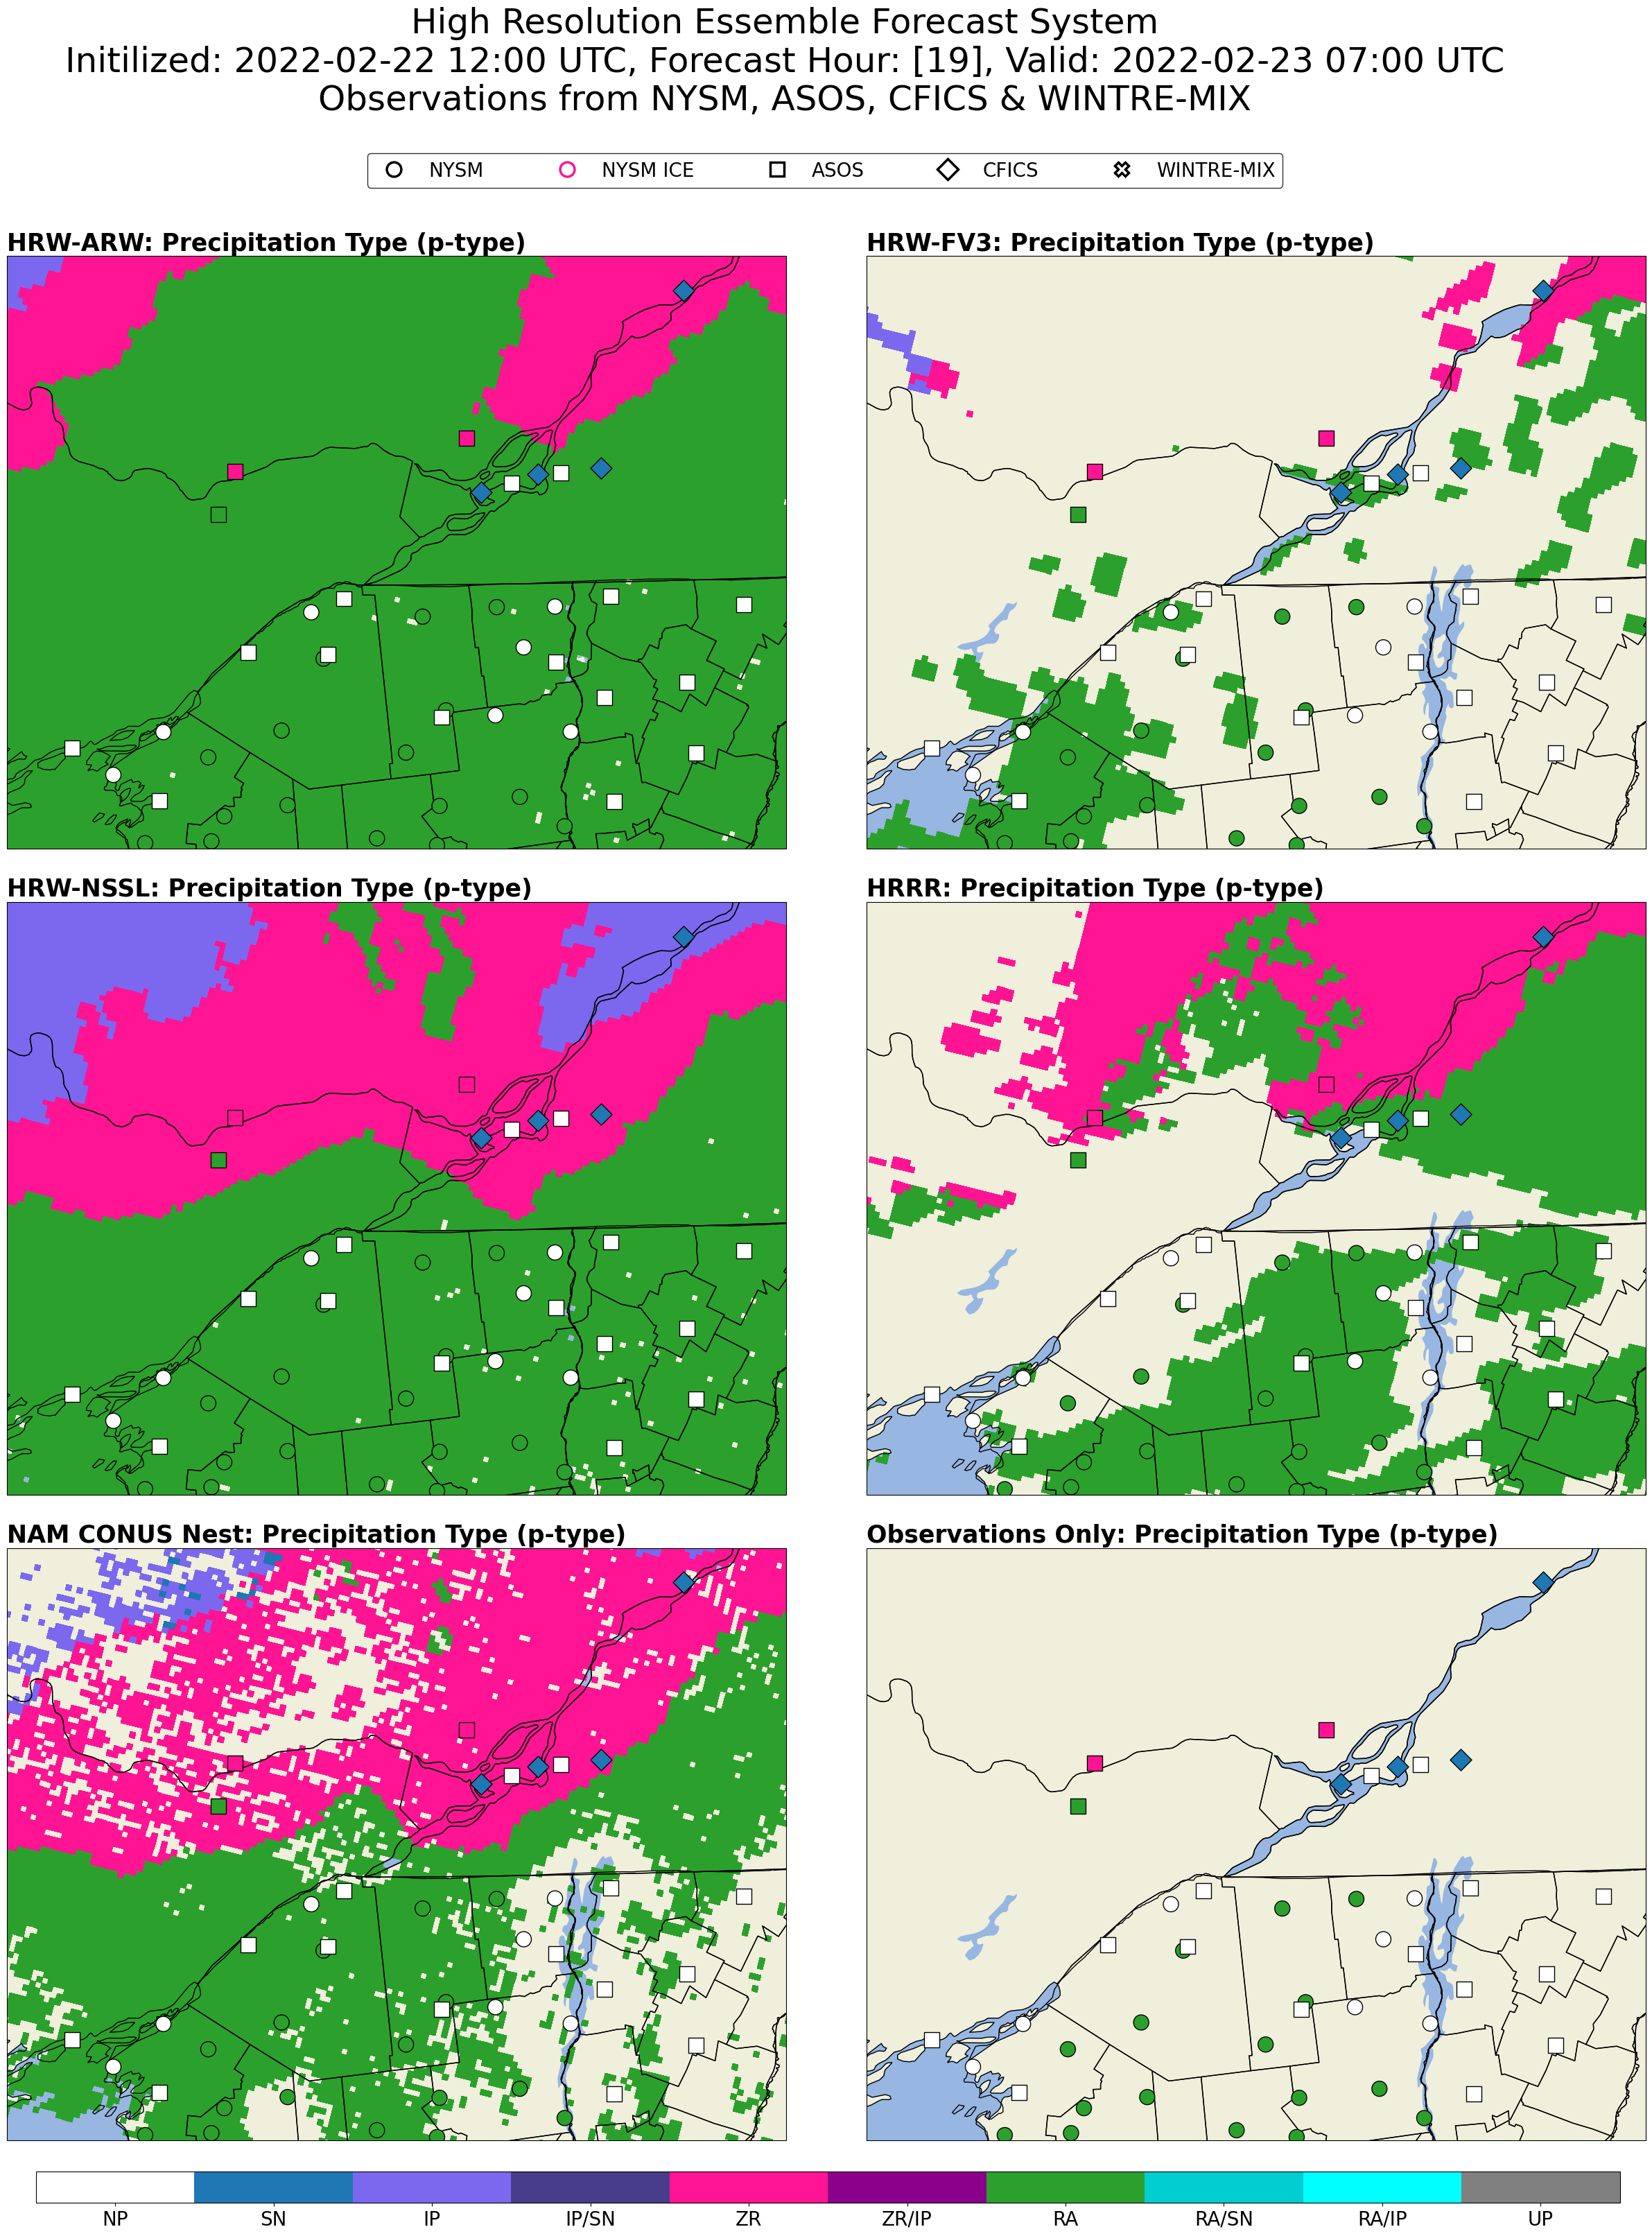

In [6]:
valid_time = datetime(year,month,day,hour,minute)
valid_time_str = valid_time.strftime("%Y-%m-%d %H:%M") 
hr = valid_time+dt.timedelta(minutes=minute_delta)
time = hr.strftime("%Y-%m-%d %H:%M")

for i in fhrs:
    # Time 
    D = int(((i-starthour)/inc)) # Used for HREF File Reference  
    time = (hr) + timedelta(hours=float(i)) 
    adjtime = time - dt.timedelta(minutes=minute_delta)
    adjtimestr = adjtime.strftime("%Y-%m-%d %H:%M") 
    nysm_adjtime = time.strftime("%H:%M")
    time_delta = (hr) - timedelta(hours=hour_delta, minutes=minute_delta)
    time_delta_str = time_delta.strftime("%Y-%m-%d %H:%M") 
    titlestrend = adjtime.strftime("%Y-%m-%d %H:%M")
    time_fzra_begin= (adjtime) - timedelta(hours=0, minutes=30)
    time_fzra_end= (adjtime) - timedelta(hours=0, minutes=-30)
    
    # Observational Data
    print("Loading In Observational Data...")
    
    # Manual Observations
    if IOP == 4:
        SO4_c = SO4.loc[SO4['Date & time (UTC)'] == adjtimestr]
        lats_SO4_c = SO4_c['lat']
        lons_SO4_c = SO4_c['lon']
        
        GA4_c = GA4.loc[GA4['Date & time (UTC)'] == adjtimestr]
        lats_GA4_c = GA4_c['lat']
        lons_GA4_c = GA4_c['lon']
        
        CC4_c = CC4.loc[CC4['Date & time (UTC)'] == adjtimestr]
        lats_CC4_c = CC4_c['lat']
        lons_CC4_c = CC4_c['lon']
        
        DC4_c = DC4.loc[DC4['Date & time (UTC)'] == adjtimestr]
        lats_DC4_c = DC4_c['lat']
        lons_DC4_c = DC4_c['lon']
        
        DU4_c = DU4.loc[DU4['Date & time (UTC)'] == adjtimestr]
        lats_DU4_c = DU4_c['lat']
        lons_DU4_c = DU4_c['lon']
        print('IOP4 Manual Observations Valid: '+ adjtimestr + ' UTC')
        
    if IOP == 5:
        SO5_c = SO5.loc[SO5['Date & time (UTC)'] == adjtimestr]
        lats_SO5_c = SO5_c['lat']
        lons_SO5_c = SO5_c['lon']
        
        GA5_c = GA5.loc[GA5['Date & time (UTC)'] == adjtimestr]
        lats_GA5_c = GA5_c['lat']
        lons_GA5_c = GA5_c['lon']
        
        TR5_c = TR5.loc[TR5['Date & time (UTC)'] == adjtimestr]
        lats_TR5_c = TR5_c['lat']
        lons_TR5_c = TR5_c['lon']
        
        CC5_c = CC5.loc[CC5['Date & time (UTC)'] == adjtimestr]
        lats_CC5_c = CC5_c['lat']
        lons_CC5_c = CC5_c['lon']
        
        DC5_c = DC5.loc[DC5['Date & time (UTC)'] == adjtimestr]
        lats_DC5_c = DC5_c['lat']
        lons_DC5_c = DC5_c['lon']
        
        DU5_c = DU5.loc[DU5['Date & time (UTC)'] == adjtimestr]
        lats_DU5_c = DU5_c['lat']
        lons_DU5_c = DU5_c['lon']
        
        print('IOP5 Manual Observations Valid: '+ adjtimestr + ' UTC')
    
    # Sentinal Observations 
    ARBO_PTYPE = sent_xr['p-type'].sel(station = 'ARBO', time = adjtime).values
    ARBO_PTYPE = np.where(ARBO_PTYPE == 13.99, 10.99, ARBO_PTYPE)
    ARBO_PTYPE = np.where(ARBO_PTYPE == 9.99, 7.99, ARBO_PTYPE)

    
    GAUL_PTYPE = sent_xr['p-type'].sel(station = 'GAUL', time = adjtime).values
    GAUL_PTYPE = np.where(GAUL_PTYPE == 13.99, 10.99, GAUL_PTYPE)
    GAUL_PTYPE = np.where(GAUL_PTYPE == 9.99, 7.99, GAUL_PTYPE)   
    
    TROI_PTYPE = sent_xr['p-type'].sel(station = 'TROI', time = adjtime).values
    TROI_PTYPE = np.where(TROI_PTYPE == 13.99, 10.99, TROI_PTYPE)
    TROI_PTYPE = np.where(TROI_PTYPE == 9.99, 7.99, TROI_PTYPE)   
    
    UQAM_PTYPE = sent_xr['p-type'].sel(station = 'UQAM', time = adjtime).values
    UQAM_PTYPE = np.where(UQAM_PTYPE == 13.99, 10.99, UQAM_PTYPE)
    UQAM_PTYPE = np.where(UQAM_PTYPE == 9.99, 7.99, UQAM_PTYPE) 
    

    # NYSM Observations
    mask_NYSM = (NYSM_ptype_cropped['time_5M'] == adjtimestr)
    NYSM_ptype_mask = NYSM_ptype_cropped.loc[mask_NYSM]
    NYSM_ptype_lat = NYSM_ptype_mask['lat']
    NYSM_ptype_lon = NYSM_ptype_mask['lon']
    NYSM_ptype = NYSM_ptype_mask['ptype'].astype(float)
    print('NYSM Valid: '+ adjtimestr + ' UTC')
    
    # ASOS
    mask_ASOS = (df_merged_cropped['valid'] > time_delta_str) & (df_merged_cropped['valid'] <= adjtimestr)
    ASOS_cropped = df_merged_cropped.loc[mask_ASOS]
    df_merged = ASOS_cropped.drop_duplicates(subset='station', keep='last', inplace=False)
    df_merged = df_merged.dropna()
    lats_ASOS_ptype = df_merged['lat']
    lons_ASOS_ptype = df_merged['lon']
    ptype_ASOS = df_merged['ptype']
    print("ASOS Valid: " + adjtimestr + ' UTC')
    
    # FZRA
    mask_NYSM_zr = ((df_feb_zr["time"] > str(time_fzra_begin)) & (df_feb_zr["time"] < str(time_fzra_end)))
    df_feb_zr_mask = df_feb_zr.loc[mask_NYSM_zr]
    NYSM_zr = df_feb_zr_mask
    #NYSM_zr = NYSM_zr.groupby(["station",'latitude','longitude'], as_index=False).agg(ice_sum=("T_i_method_2", "sum"))
    NYSM_zr = NYSM_zr.groupby(["station",'latitude','longitude'], as_index=False).agg(ice_sum=("Icing_flag", "sum"))
    NYSM_zr = NYSM_zr[NYSM_zr['ice_sum'] != 0] #uncomment out if you just want to see times where it was precipitating
    lats_NYSM_zr = NYSM_zr['latitude']
    lons_NYSM_zr = NYSM_zr['longitude']
    NYSM_zr = NYSM_zr['ice_sum']
    print('NYSM FZRA Valid: '+ adjtimestr + ' UTC', NYSM_zr)
    print()
    
    if href_flag == 'OFF': 

        # HREF 
        import xarray as xr
        print("Loading In HREF Data...")
        hrefN, hrefS, hrefE, hrefW = latN+.7, latS-.9, lonE+360.5 , lonW+359

        # ARW RA
        with xr.open_mfdataset(arw[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029}) as arw_cr:
            arw_rain = arw_cr['crain'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        #ARW FZRA
        with xr.open_mfdataset(arw[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as arw_cf:
            arw_fzra = arw_cf['cfrzr'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # ARW PL
        with xr.open_mfdataset(arw[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031}) as arw_ip:
            arw_icep = arw_ip['cicep'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # ARW SN
        with xr.open_mfdataset(arw[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032}) as arw_sn:
            arw_snow = arw_sn['csnow'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))
            print('ARW Valid: '+ adjtimestr + ' UTC')

        # FV3 RA
        with xr.open_mfdataset(fv3[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029}) as fv3_cr:
            fv3_rain = fv3_cr['crain'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # FV3 FZRA
        with xr.open_mfdataset(fv3[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as fv3_cf:
            fv3_fzra = fv3_cf['cfrzr'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # FV3 PL
        with xr.open_mfdataset(fv3[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031}) as fv3_ip:
            fv3_icep = fv3_ip['cicep'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # FV3 SN
        with xr.open_mfdataset(fv3[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032}) as fv3_sn:
            fv3_snow = fv3_sn['csnow'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))
            print('FV3 Valid: '+ adjtimestr + ' UTC')

        # NSSL RA
        with xr.open_mfdataset(nssl[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029}) as nssl_cr:
            nssl_rain = nssl_cr['crain'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # NSSL FZRA
        with xr.open_mfdataset(nssl[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as nssl_cf:
            nssl_fzra = nssl_cf['cfrzr'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # NSSL PL
        with xr.open_mfdataset(nssl[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031}) as nssl_ip:
            nssl_icep = nssl_ip['cicep'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # NSSL SN
        with xr.open_mfdataset(nssl[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032}) as nssl_sn:
            nssl_snow = nssl_sn['csnow'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))
            print('NSSL Valid: '+ adjtimestr + ' UTC')

        # NCEP RA
        with xr.open_mfdataset(ncep[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029}) as ncep_cr:
            ncep_rain = ncep_cr['crain'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # NCEP FZRA
        with xr.open_mfdataset(ncep[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as ncep_cf:
            ncep_fzra = ncep_cf['cfrzr'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # NCEP PL
        with xr.open_mfdataset(ncep[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031}) as ncep_ip:
            ncep_icep = ncep_ip['cicep'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # NCEP SN
        with xr.open_mfdataset(ncep[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032}) as ncep_sn:
            ncep_snow = ncep_sn['csnow'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))
            print('NCEP Valid: '+ adjtimestr + ' UTC')

        # NAM RA
        with xr.open_mfdataset(nam[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029}) as nam_cr:
            nam_rain = nam_cr['crain'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # NAM FZRA
        with xr.open_mfdataset(nam[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as nam_cf:
            nam_fzra = nam_cf['cfrzr'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # NAM PL
        with xr.open_mfdataset(nam[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031}) as nam_ip:
            nam_icep = nam_ip['cicep'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))

        # NAM SN
        with xr.open_mfdataset(nam[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032}) as nam_sn:
            nam_snow = nam_sn['csnow'].where((arw_cr.latitude >= hrefS) & (arw_cr.latitude <= hrefN) & (arw_cr.longitude >= hrefW) & (arw_cr.longitude <= hrefE))
            print('NAM Valid: '+ adjtimestr + ' UTC')
            print()

        # Deriving Precipitation Type from combinations of NCEP catagorical precip
        ncep_icep_fzra = np.add(ncep_icep,ncep_fzra)
        ncep_icep_snow = np.add(ncep_icep,ncep_snow)
        ncep_rain_snow = np.add(ncep_rain,ncep_snow)
        ncep_rain_icep = np.add(ncep_rain,ncep_icep)

        # Defining a random variable to make a Latitude and Longitude we can use for plotting HREF members and their catagories
        lats = arw_rain['latitude']
        lons = arw_rain['longitude']
    
    # Defining Basic Plot Features
    def features(ax):
        
        # Features 
        ax.set_extent ([lonW,lonE,latS,latN]) # Cartopy Land
        norm = mpl.colors.Normalize(-10, 100)
        ax.add_feature (cfeature.LAND.with_scale(res), zorder=1) # Cartopy Land
        ax.add_feature (cfeature.OCEAN.with_scale(res), zorder=1) # Cartopy Ocean
        ax.add_feature (cfeature.LAKES.with_scale(res), zorder=1) # Cartopy Lakes
        ax.add_feature (cfeature.COASTLINE.with_scale(res), zorder = 3) # Cartopy Coastline
        ax.add_feature (cfeature.STATES.with_scale(res), zorder = 3) # Cartopy US State Boundaries
        ax.add_feature(USCOUNTIES.with_scale(county_scale),zorder= 3, linewidth = county_lw) # Cartopy US County Boundaries
        
        # NYSM Observations
        ax.scatter(NYSM_ptype_lon, NYSM_ptype_lat, s = msize, c = NYSM_ptype, cmap = cmap_ptype_ext,norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, label='NYSM', edgecolor=color) # Plotting NYSM Sites and Data
        
        # NYSM FZRA Observations
        #ax.scatter(lons_NYSM_zr, lats_NYSM_zr, marker = 7,s = msize+1, c = 'deeppink', cmap = my_cmap_fzra, norm=norm,transform = ccrs.PlateCarree(), linewidths=2, zorder = 5, edgecolor=color) # Plotting NYSM FZRA Rings
        ax.scatter(lons_NYSM_zr, lats_NYSM_zr,s = msize+10, cmap = my_cmap_fzra, norm=norm,transform = ccrs.PlateCarree(), linewidths=2, zorder = 5, edgecolor='deeppink') # Plotting NYSM FZRA Rings

        # ASOS Observations
        ax.scatter(lons_ASOS_ptype, lats_ASOS_ptype, s = msize, c = ptype_ASOS, cmap = cmap_ptype_ext, norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker='s', label='ASOS', edgecolor=color) # Plotting ASOS Sites and Data
        
        # Sentinal Station Observations
        ax.scatter(-73.942156,45.430065, s = msize, c = ARBO_PTYPE, cmap = cmap_ptype_ext, norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker='D', label='SENT', edgecolor=color) 
        ax.scatter(-73.149006,45.535021, s = msize, c = GAUL_PTYPE, cmap = cmap_ptype_ext, norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker='D', label='SENT', edgecolor=color) 
        ax.scatter(-72.581354,46.349835, s = msize, c = TROI_PTYPE, cmap = cmap_ptype_ext, norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker='D', label='SENT', edgecolor=color) 
        ax.scatter(-73.568741,45.508594, s = msize, c = UQAM_PTYPE, cmap = cmap_ptype_ext, norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker='D', label='SENT', edgecolor=color)

        shape_obs = 'X'
        if IOP == 4: # WINTRE-MIX Manual Ground Observations
            ax.scatter(lons_SO4_c, lats_SO4_c, s = msize+50, c = SO4_c['Primary p-type']-1, cmap = cmap_ptype_ext,norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker = shape_obs,label='WINTRE-MIX', edgecolor=color) 
            ax.scatter(lons_GA4_c, lats_GA4_c, s = msize+50, c = GA4_c['Primary p-type']-1, cmap = cmap_ptype_ext,norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker = shape_obs,label='WINTRE-MIX', edgecolor=color) 
            ax.scatter(lons_CC4_c, lats_CC4_c, s = msize+50, c = CC4_c['Primary p-type']-1, cmap = cmap_ptype_ext,norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker = shape_obs,label='WINTRE-MIX', edgecolor=color) 
            ax.scatter(lons_DC4_c, lats_DC4_c, s = msize+50, c = DC4_c['Primary p-type']-1, cmap = cmap_ptype_ext,norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker = shape_obs,label='WINTRE-MIX', edgecolor=color) 
            ax.scatter(lons_DU4_c, lats_DU4_c, s = msize+50, c = DU4_c['Primary p-type']-1, cmap = cmap_ptype_ext,norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker = shape_obs,label='WINTRE-MIX', edgecolor=color) 
        if IOP == 5: # WINTRE-MIX Manual Ground Observations
            ax.scatter(lons_SO5_c, lats_SO5_c, s = msize+50, c = SO5_c['Primary p-type']-1, cmap = cmap_ptype_ext,norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker = shape_obs,label='WINTRE-MIX', edgecolor=color)
            ax.scatter(lons_GA5_c, lats_GA5_c, s = msize+50, c = GA5_c['Primary p-type']-1, cmap = cmap_ptype_ext,norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker = shape_obs,label='WINTRE-MIX', edgecolor=color)
            ax.scatter(lons_TR5_c, lats_TR5_c, s = msize+50, c = TR5_c['Primary p-type']-1, cmap = cmap_ptype_ext,norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker = shape_obs,label='WINTRE-MIX', edgecolor=color) 
            ax.scatter(lons_CC5_c, lats_CC5_c, s = msize+50, c = CC5_c['Primary p-type']-1, cmap = cmap_ptype_ext,norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker = shape_obs,label='WINTRE-MIX', edgecolor=color)
            ax.scatter(lons_DC5_c, lats_DC5_c, s = msize+50, c = DC5_c['Primary p-type']-1, cmap = cmap_ptype_ext,norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker = shape_obs,label='WINTRE-MIX', edgecolor=color) 
            ax.scatter(lons_DU5_c, lats_DU5_c, s = msize+50, c = DU5_c['Primary p-type']-1, cmap = cmap_ptype_ext,norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker = shape_obs,label='WINTRE-MIX', edgecolor=color) 
    
    def legend(ax):
        ASOS = mlines.Line2D([], [], color=c, marker='s', ls='', label='ASOS', markeredgecolor=color, markeredgewidth = 2.5) # ASOS legend definition
        NYSM = mlines.Line2D([], [], color=c, marker='o', ls='', label='NYSM', markeredgecolor=color, markeredgewidth = 2.5) # NYSM legend definition
        ICED = mlines.Line2D([], [], color=c, marker= 'o' , ls='', label='NYSM ICE', markeredgecolor='deeppink', markeredgewidth = 2.5) # NYSM legend definition
        WINTRE_MIX = mlines.Line2D([], [], color=c, marker='X', ls='', label='WINTRE-MIX', markeredgecolor=color, markeredgewidth = 2.5) # WINTRE-MIX legend definition
        CFICS = mlines.Line2D([], [], color=c, marker='D', ls='', label='CFICS', markeredgecolor=color, markeredgewidth = 2.5) # WINTRE-MIX legend definition
        ax.legend(loc='upper center',handles=[NYSM, ICED, ASOS, CFICS, WINTRE_MIX],frameon=True,fontsize=20,shadow = False,edgecolor = 'black',mode = "expand", ncol = 6,markerscale=2.5,bbox_to_anchor=(0.45, -.05, 1.2,1.24))

    # Text
    tl0 = 'High Resolution Essemble Forecast System'
    tl1 = 'Observations from NYSM, ASOS, CFICS & WINTRE-MIX'
    tl2 = f'Initilized: {valid_time_str} UTC, Forecast Hour: [{i}], Valid: {titlestrend} UTC'    
    title_line = (tl0+ '\n' + tl2 + '\n' + tl1)
    variable = 'Precipitation Type (p-type)'
    model1_t = 'HRW-ARW: ' + variable
    model2_t = 'HRW-FV3: ' + variable
    model3_t = 'HRW-NSSL: ' + variable
    model4_t = 'HRRR: ' + variable
    model5_t = 'NAM CONUS Nest: ' + variable
    model6_t = 'Observations Only: ' + variable
    titletime = valid_time.strftime("%Y%m%d%H") 
    savefiguretitle = f'ptype_{str(titletime)}_{i}'    
    
    latN = 46.5 # North
    latS = 43.75 # South
    lonW = -77 # West
    lonE = -72 # East
    cLat = (latN + latS)/2 # Central Latitude
    cLon = (lonW + lonE )/2 # Central Longitude
    
    # Figure Parameters
    res = '10m' # Resolution 
    c = 'white' # Color For Interior of legend Symbols
    proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat) # Projection over a central lon. and lat.
    msize = 250 # Controls the size of all NYSM, ASOS and mPING "points" projected onto the figures
    color ='black' # Border Color of all NYSM, ASOS and mPING "points"
    county_lw, county_scale = 1.0, '5m' # Used to scale the county borders. 
    o = 25
    
    # Precipitation Type Figure
    fig = plt.figure(figsize=(48,36),dpi=100) # Main Figure SIze and DPI
    fig.suptitle(title_line, fontsize = 36) # Main Figure Title
    plt.subplots_adjust(hspace = 0.09)#0.09 # Adjusts seperation between subplots (Height)
    plt.subplots_adjust(wspace = -0.5)#-0.5 # Adjusts seperation between subplots (Width)
    
    # NYSM, mPING, ASOS, WINTRE-MIX Sites & ARW Member of HREF
    ax1 = fig.add_subplot(3,2,1, projection=proj) # Setting up subplot & projection
    ax1.set_title(model1_t,fontsize=o,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
    features(ax1) # Plots Observational Reports (mPING, NYSM, ASOS) & Map Features (Land, Water, States, Counties, etc.) 
    legend(ax1)
    
    # NYSM, mPING, ASOS, WINTRE-MIX Sites & FV3 Member of HREF
    ax2 = fig.add_subplot(3,2,2, projection=proj) # Setting up subplot & projection
    ax2.set_title(model2_t,fontsize=o,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
    features(ax2) # Plots Observational Reports (mPING, NYSM, ASOS) & Map Features (Land, Water, States, Counties, etc.) 

    # NYSM, mPING, ASOS, WINTRE-MIX Sites & NSSL Member of HREF
    ax3 = fig.add_subplot(3,2,3, projection=proj) # Setting up subplot & projection
    ax3.set_title(model3_t,fontsize=o,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
    features(ax3) # Plots Observational Reports (mPING, NYSM, ASOS) & Map Features (Land, Water, States, Counties, etc.) 

    # NYSM, mPING, ASOS, WINTRE-MIX Sites & NCEP Member of HREF
    ax4 = fig.add_subplot(3,2,4, projection=proj) # Setting up subplot & projection
    ax4.set_title(model4_t,fontsize=o,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
    features(ax4) # Plots Observational Reports (mPING, NYSM, ASOS) & Map Features (Land, Water, States, Counties, etc.) 

    # NYSM, mPING, ASOS, WINTRE-MIX Sites & NAM Member of HREF
    ax5 = fig.add_subplot(3,2,5, projection=proj) # Setting up subplot & projection
    ax5.set_title(model5_t,fontsize=o,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
    features(ax5) # Plots Observational Reports (mPING, NYSM, ASOS) & Map Features (Land, Water, States, Counties, etc.) 

    
    if href_flag == 'OFF': 
        ax1.pcolormesh(lons, lats, arw_rain, cmap = my_cmap_rain, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Rain
        ax1.pcolormesh(lons, lats, arw_fzra, cmap = my_cmap_fzra, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Freezing Rain
        ax1.pcolormesh(lons, lats, arw_icep, cmap = my_cmap_icep, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Ice Pellets
        ax1.pcolormesh(lons, lats, arw_snow, cmap = my_cmap_snow, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Snow
        ax2.pcolormesh(lons, lats, fv3_rain, cmap = my_cmap_rain, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Rain
        ax2.pcolormesh(lons, lats, fv3_fzra, cmap = my_cmap_fzra, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Freezing Rain
        ax2.pcolormesh(lons, lats, fv3_icep, cmap = my_cmap_icep, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Ice Pellets
        ax2.pcolormesh(lons, lats, fv3_snow, cmap = my_cmap_snow, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Snow
        ax3.pcolormesh(lons, lats, nssl_rain, cmap = my_cmap_rain, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Rain
        ax3.pcolormesh(lons, lats, nssl_snow, cmap = my_cmap_snow, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Freezing Rain
        ax3.pcolormesh(lons, lats, nssl_fzra, cmap = my_cmap_fzra, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Ice Pellets
        ax3.pcolormesh(lons, lats, nssl_icep, cmap = my_cmap_icep, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Snow
        ax4.pcolormesh(lons, lats, ncep_rain, cmap = my_cmap_rain, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Rain
        ax4.pcolormesh(lons, lats, ncep_fzra, cmap = my_cmap_fzra, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Freezing Rain
        ax4.pcolormesh(lons, lats, ncep_icep, cmap = my_cmap_icep, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Ice Pellets
        ax4.pcolormesh(lons, lats, ncep_snow, cmap = my_cmap_snow, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Snow
        ax4.pcolormesh(lons, lats, ncep_icep_fzra, cmap = my_cmap_fzra_icep, norm = norm_ptype, transform = ccrs.PlateCarree(), zorder = 2) # Derived HREF Member Freezing Rain and Ice Pellets
        ax4.pcolormesh(lons, lats, ncep_icep_snow, cmap = my_cmap_icep_snow, norm = norm_ptype, transform = ccrs.PlateCarree(), zorder = 2) # Derived HREF Member Snow and Ice Pellets
        ax4.pcolormesh(lons, lats, ncep_rain_snow, cmap = my_cmap_rain_snow, norm = norm_ptype, transform = ccrs.PlateCarree(), zorder = 2) # Derived HREF Member Snow and Rain
        ax4.pcolormesh(lons, lats, ncep_rain_icep, cmap = my_cmap_rain_icep, norm = norm_ptype, transform = ccrs.PlateCarree(), zorder = 2) # Derived HREF Member Rain and Ice Pellets
        ax5.pcolormesh(lons, lats, nam_rain, cmap = my_cmap_rain, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Rain
        ax5.pcolormesh(lons, lats, nam_fzra, cmap = my_cmap_fzra, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Freezing Rain
        ax5.pcolormesh(lons, lats, nam_icep, cmap = my_cmap_icep, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Ice Pellets
        ax5.pcolormesh(lons, lats, nam_snow, cmap = my_cmap_snow, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Snow
    
    # NYSM, mPING, ASOS, WINTRE-MIX Sites & NAM Member of HREF
    ax6 = fig.add_subplot(3,2,6, projection=proj) # Setting up subplot & projection
    ax6.set_title(model6_t,fontsize=o,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
    features(ax6) # Plots Observational Reports (mPING, NYSM, ASOS) & Map Features (Land, Water, States, Counties, etc.) 
    
    if figure_flag == 'OFF':
        # Colorbar
        colorbar_axes = fig.add_axes([0.275, 0.1, .476, .0125])# Left Bottom Width Height
        cbar = plt.colorbar(cbar_ptype, orientation = 'horizontal', ticks = ptype_ticks, aspect = 35, cax = colorbar_axes)
        cbar.ax.set_xticklabels(ptype_labels)
        cbar.ax.tick_params(labelsize=20)   
    
    # Save Individual Figure
    if href_flag == 'OFF': 
        fig.savefig(savefiguretitle)

### **5 Pannel Output**

England, John | LU: 20230128